GOES CRS:
+proj=geos +h=35786023.0 +lon_0=-137.0 +sweep=x +a=6378137.0 +b=6356752.31414 +units=m +no_defs

✅ Shapefiles saved:
E:\GOES-R Lightning Data\GEOS-REPROJECT-LAYERS\world_borders_geos.shp
E:\GOES-R Lightning Data\GEOS-REPROJECT-LAYERS\graticule_10deg_geos.shp


C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 211049527 of field POP_EST of feature 6 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 127575529 of field POP_EST of feature 26 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 328239523 of field POP_EST of feature 28 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\micha\AppData\Local\Pac

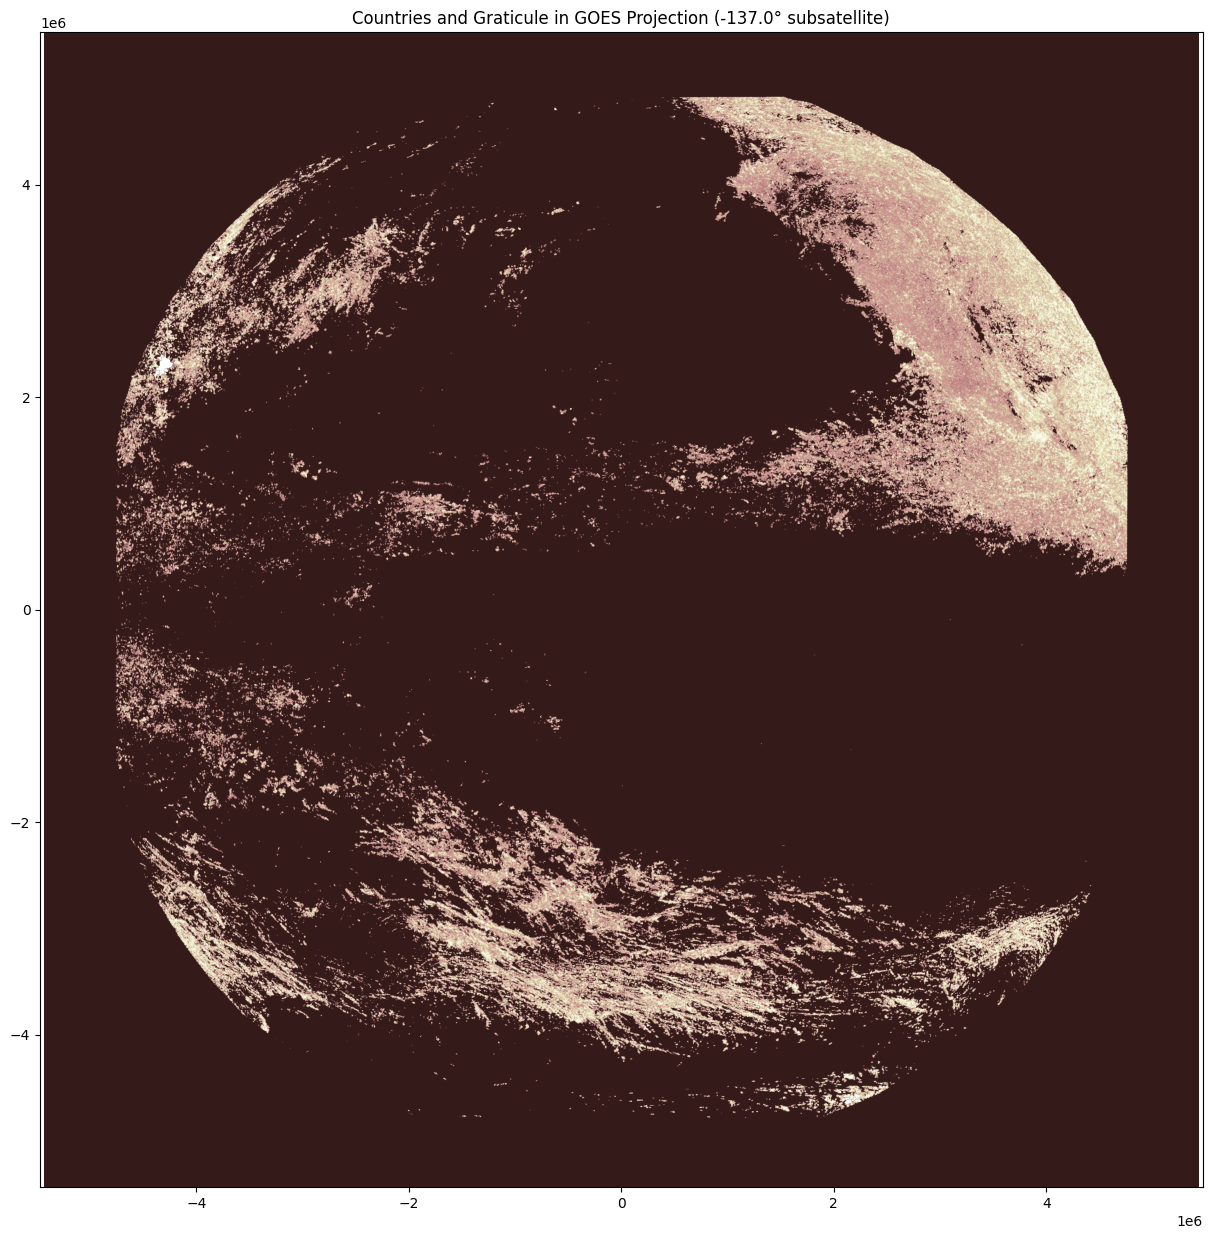

In [10]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# -------------------------------
# --- USER INPUTS ---------------
# -------------------------------
netcdf_path = r"E:\GOES-R Lightning Data\WEST-2025\OR_GLM-L3-GLMF-M6_G18_s202518123590000_e202518200000000_c20251820001000.nc"
countries_path = r"E:\GOES-R Lightning Data\GEOS-REPROJECT-LAYERS\countries-natural-earth\ne_110m_admin_0_countries.shp"
output_dir = r"E:\GOES-R Lightning Data\GEOS-REPROJECT-LAYERS"
grid_spacing = 10  # degrees

# -------------------------------
# --- 1. Load GOES projection from NetCDF ---
# -------------------------------
ds = xr.open_dataset(netcdf_path)
proj_var = ds['goes_imager_projection']

h = float(proj_var.perspective_point_height)
lon_0 = float(proj_var.longitude_of_projection_origin)
sweep = str(proj_var.sweep_angle_axis)
a = float(proj_var.semi_major_axis)
b = float(proj_var.semi_minor_axis)

goes_crs = f"+proj=geos +h={h} +lon_0={lon_0} +sweep={sweep} +a={a} +b={b} +units=m +no_defs"
print(f"GOES CRS:\n{goes_crs}")

# -------------------------------
# --- 2. Load countries shapefile ---
# -------------------------------
world = gpd.read_file(countries_path)

# -------------------------------
# --- 3. Define visible disk in lat/lon ---
# -------------------------------
# Visible radius from sub-satellite point (roughly)
lat_max = 81
lon_max = 81

# Create circular disk points
num_points = 360
angles = np.linspace(0, 2*np.pi, num_points)
disk_lon = lon_0 + lon_max * np.cos(angles)
disk_lat = 0 + lat_max * np.sin(angles)
visible_disk = Polygon(zip(disk_lon, disk_lat))
visible_gdf = gpd.GeoDataFrame(geometry=[visible_disk], crs="EPSG:4326")

# -------------------------------
# --- 4. Clip countries to visible disk ---
# -------------------------------
world_clipped = gpd.clip(world, visible_gdf)

# -------------------------------
# --- 5. Create graticules only inside disk ---
# -------------------------------
lats = np.arange(-lat_max, lat_max + 1, grid_spacing)
lons = np.arange(lon_0 - lon_max, lon_0 + lon_max + 1, grid_spacing)

lines = []

# Only include points within the circular disk
for lon in lons:
    pts = [Point(lon, lat) for lat in lats if visible_disk.contains(Point(lon, lat))]
    if len(pts) >= 2:
        lines.append(LineString(pts))

for lat in lats:
    pts = [Point(lon, lat) for lon in lons if visible_disk.contains(Point(lon, lat))]
    if len(pts) >= 2:
        lines.append(LineString(pts))

graticule = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

# -------------------------------
# --- 6. Reproject clipped layers to GOES CRS ---
# -------------------------------
world_goes = world_clipped.to_crs(goes_crs)
graticule_goes = graticule.to_crs(goes_crs)

# -------------------------------
# --- 7. Save shapefiles ---
# -------------------------------
os.makedirs(output_dir, exist_ok=True)
world_out = os.path.join(output_dir, "world_borders_geos.shp")
grid_out = os.path.join(output_dir, f"graticule_{grid_spacing}deg_geos.shp")

world_goes.to_file(world_out)
graticule_goes.to_file(grid_out)

print(f"\n✅ Shapefiles saved:\n{world_out}\n{grid_out}")

# -------------------------------
# --- 8. Quick plot for verification ---
# -------------------------------
fig, ax = plt.subplots(figsize=(15, 15))
#graticule_goes.plot(ax=ax, color='lightgray', linewidth=0.5)
#world_goes.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_title(f"Countries and Graticule in GOES Projection ({lon_0}° subsatellite)")

# --- Paths ---
raster_path = r"E:\GOES-R Lightning Data\WEST-RASTERS\west_mean_energy_2025_georef.tif"

# --- 1. Open the raster ---
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # single band
    raster_extent = (
        src.bounds.left, src.bounds.right,
        src.bounds.bottom, src.bounds.top
    )

show(raster_data, extent=raster_extent, ax=ax, cmap='pink', alpha=0.9)

plt.axis('equal')
plt.show()
